In [14]:
import ctypes
import os
import time
import numpy as np
import matplotlib.pyplot as plt

#load lib
lib_path = os.path.abspath("libpmu.so")
pmu = ctypes.CDLL(lib_path)

#set return type for unsigned 32-bit
pmu.get_cycle_count.restype = ctypes.c_uint64

#init PMU
pmu.init_pmu()

#check
pmu.init_pmu()
initial_count = pmu.get_cycle_count()

print(f"PMU initialized.")
print(f"Start Cycle Count: {initial_count}")

PMU initialized.
Start Cycle Count: 8317987317336046579


In [15]:
def recur_fibo(n):
    if n <= 1: return n
    else: return(recur_fibo(n-1) + recur_fibo(n-2))

#params
n_values = [1, 5, 10, 15, 20, 25, 28, 30] 
trials = 3
data_log = []

for n in n_values:
    c_results = []
    t_results = []
    
    print(f"running n={n}...")
    for _ in range(trials):
        #start
        c_before = pmu.get_cycle_count()
        t_before = time.perf_counter()
        
        #execute
        recur_fibo(n)
        
        #end
        t_after = time.perf_counter()
        c_after = pmu.get_cycle_count()
        
        #calculate deltas (handle 32-bit wrap-around with & 0xFFFFFFFF)
        c_results.append((c_after - c_before) & 0xFFFFFFFF)
        t_results.append(t_after - t_before)
    
    #mean and std error
    avg_c = np.mean(c_results)
    err_c = np.std(c_results) / np.sqrt(trials)
    
    avg_t = np.mean(t_results)
    err_t = np.std(t_results) / np.sqrt(trials)
    
    data_log.append([n, avg_c, err_c, avg_t, err_t])

data = np.array(data_log)
print("Done w/ data")

running n=1...
running n=5...
running n=10...
running n=15...
running n=20...
running n=25...
running n=28...
running n=30...
Done w/ data


In [16]:
plot_data = data[1:]#skip the first cycle, abnomrally high

#extract columns from the 'data' array
#data_log.append([n, avg_c, err_c, avg_t, err_t])
n_vals = data[:, 0]
avg_cycles = data[:, 1]
err_cycles = data[:, 2]
avg_time = data[:, 3]
err_time = data[:, 4]

#conversion factor for PYNQ-Z2
CPU_FREQ = 650e6  # 650 MHz

#convert PMU cycles to calculated time
pmu_time_converted = avg_cycles / CPU_FREQ

#compare the results for n=30
print(f"n=30 PMU Calculated Time: {pmu_time_converted[-1]:.6f} s")
print(f"n=30 Python Time Module: {avg_time[-1]:.6f} s")

n=30 PMU Calculated Time: 4.475562 s
n=30 Python Time Module: 4.476811 s


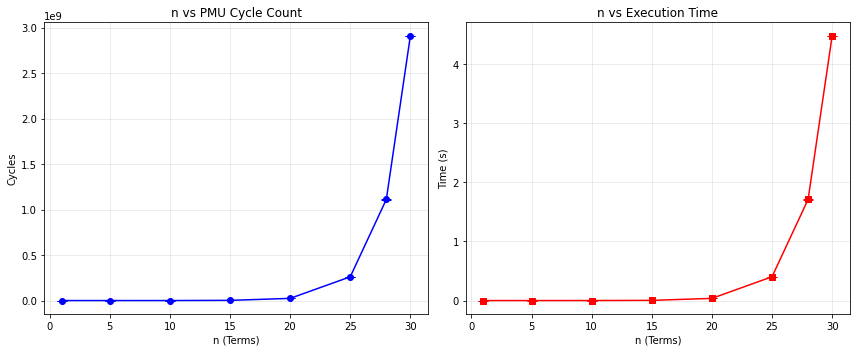

In [17]:
#plot me
plt.figure(figsize=(12, 5))

#n =5 to 30

#cycle Count (
plt.subplot(1, 2, 1)
plt.errorbar(n_vals, avg_cycles, yerr=err_cycles, fmt='-o', capsize=5, color='blue')
plt.title('n vs PMU Cycle Count')
plt.xlabel('n (Terms)')
plt.ylabel('Cycles')
plt.grid(True, alpha=0.3)

# execution Time
plt.subplot(1, 2, 2)
plt.errorbar(n_vals, avg_time, yerr=err_time, fmt='-s', capsize=5, color='red')
plt.title('n vs Execution Time')
plt.xlabel('n (Terms)')
plt.ylabel('Time (s)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()